### En este Notebook se buscara realizar un entendimiento inicial de los datos de los registros medicos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Ruta al archivo Excel
excel_path = "C:\\Users\\wired\\Downloads\\Proyecto_Final_Applied_Data_Science\\Notebooks\\data\\Base entrega.xlsx"

# Cargar el archivo Excel para explorar sus hojas
excel_file = pd.ExcelFile(excel_path)

# Ver los nombres de todas las hojas
print("Hojas disponibles en el Excel:")
for i, sheet in enumerate(excel_file.sheet_names):
    print(f"{i+1}. {sheet}")

Hojas disponibles en el Excel:
1. data
2. personales
3. DX
4. laboratorios
5. motivoConsulta


## Convertir cada hoja a CSV

Esto facilitará el trabajo futuro y mejorará el rendimiento del análisis.

In [3]:
import os

# Crear carpeta para los CSV si no existe
csv_folder = "C:\\Users\\wired\\Downloads\\Proyecto_Final_Applied_Data_Science\\Notebooks\\data\\csv"
os.makedirs(csv_folder, exist_ok=True)

# Convertir cada hoja a CSV
for sheet_name in excel_file.sheet_names:
    # Leer la hoja
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
    # Crear nombre del archivo CSV (reemplazar caracteres especiales)
    csv_filename = sheet_name.replace(" ", "_").replace("/", "-")
    csv_path = os.path.join(csv_folder, f"{csv_filename}.csv")
    
    # Guardar como CSV
    df.to_csv(csv_path, index=False, encoding='utf-8-sig')


### Analisis Exploratorio de datos por hoja

### 3. Hoja: DX

In [ ]:
# Cargar hoja 'DX'
df_dx = pd.read_csv(f"{csv_folder}/DX.csv")
print(f"Dimensiones: {df_dx.shape}")
print(f"Columnas: {list(df_dx.columns)}")
df_dx.head()

Dimensiones: (900, 8)
Columnas: ['EVENTO', 'Codigo', 'FIBROSIS', 'NUMPACIENTE', 'DIAGNOSTICO', 'NOMBRE_DIAGNOSTICO', 'PRINCIPAL', 'FECHA_DIAGNOSTICO']


,EVENTO,Codigo,FIBROSIS,NUMPACIENTE,DIAGNOSTICO,NOMBRE_DIAGNOSTICO,PRINCIPAL,FECHA_DIAGNOSTICO
0,31,2-10,F2,58,E660,OBESIDAD DEBIDA A EXCESO DE CALORIAS,N,2023-05-23 08:42:52
1,32,2-10,F2,58,K760,"DEGENERACION GRASA DEL HIGADO, NO CLASIFICADAS...",N,2023-05-23 09:42:43
2,46,2-10,F2,58,K740,FIBROSIS HEPATICA,N,2024-05-24 15:44:58
3,41,2-10,F2,58,R945,RESULTADOS ANORMALES EN ESTUDIOS FUNCIONALES D...,N,2024-02-14 16:02:28
4,38,2-10,F2,58,K760,"DEGENERACION GRASA DEL HIGADO, NO CLASIFICADAS...",N,2023-12-21 14:51:22


### Analisis Univariado y Bivariado

In [ ]:
eventos_unicos = df_dx["EVENTO"].nunique()
pacientes_unicos = df_dx["NUMPACIENTE"].nunique()
total_registros = len(df_dx)

print(f"Total de registros: {total_registros}")
print(f"Total de eventos únicos: {eventos_unicos}")
print(f"Total de pacientes únicos: {pacientes_unicos}")
print(f"Promedio de eventos por paciente: {eventos_unicos / pacientes_unicos:.2f}")


Total de registros: 900
Total de eventos únicos: 108
Total de pacientes únicos: 94
Promedio de eventos por paciente: 1.15


In [ ]:
df_dx.groupby("NUMPACIENTE")["EVENTO"].nunique().describe()


count    94.000000
mean      8.563830
std      10.597787
min       1.000000
25%       2.000000
50%       5.000000
75%      10.000000
max      63.000000
Name: EVENTO, dtype: float64

In [ ]:
df_dx["FIBROSIS"].value_counts()

FIBROSIS
F1    299
F4    243
F3    221
F2     91
F0     46
Name: count, dtype: int64

In [ ]:
fibrosis_por_paciente = df_dx.groupby("NUMPACIENTE")["FIBROSIS"].nunique()
print("Pacientes con más de un estadio de fibrosis:", (fibrosis_por_paciente > 1).sum())


Pacientes con más de un estadio de fibrosis: 0


In [ ]:
# Contar el número de eventos por paciente
eventos_por_paciente = (
    df_dx.groupby("NUMPACIENTE")["EVENTO"]
    .count()
    .reset_index(name="num_eventos")
    .sort_values(by="num_eventos", ascending=False)
)

# Obtener el Top 3 de pacientes con más eventos
top3_pacientes = eventos_por_paciente.head(3)

# Cruzar con la información de fibrosis
top3_fibrosis = (
    df_dx.merge(top3_pacientes, on="NUMPACIENTE")[["NUMPACIENTE", "FIBROSIS", "num_eventos"]]
    .drop_duplicates(subset=["NUMPACIENTE"])
    .sort_values(by="num_eventos", ascending=False)
)

print("Top 3 pacientes con mayor número de eventos y su estado de fibrosis:\n")
print(top3_fibrosis.to_string(index=False))


Top 3 pacientes con mayor número de eventos y su estado de fibrosis:

 NUMPACIENTE FIBROSIS  num_eventos
          80       F3           70
          27       F1           49
          15       F1           49


Esta hoja no evidencia una evolucion de la estadia de la enefermedad en los pacientes a traves del tiempo.

In [ ]:
# Obtener el diagnóstico más frecuente por cada estadio
diagnostico_top = (
    df_dx.groupby("FIBROSIS")["NOMBRE_DIAGNOSTICO"]
    .agg(lambda x: x.value_counts().idxmax())
)

print("Diagnóstico más frecuente por estadio de fibrosis:\n")
for fibrosis, diag in diagnostico_top.items():
    print(f"{fibrosis}: {diag}")



Diagnóstico más frecuente por estadio de fibrosis:

F0: DEGENERACION GRASA DEL HIGADO, NO CLASIFICADAS EN OTRA PARTE
F1: DEGENERACION GRASA DEL HIGADO, NO CLASIFICADAS EN OTRA PARTE
F2: DEGENERACION GRASA DEL HIGADO, NO CLASIFICADAS EN OTRA PARTE
F3: OTRAS CIRROSIS DEL HIGADO Y LAS NO ESPECIFICADAS
F4: OTRAS CIRROSIS DEL HIGADO Y LAS NO ESPECIFICADAS


En los estadios F0, F1 y F2 predomina el diagnóstico de *degeneración grasa del hígado*, lo que indica que en las fases tempranas la enfermedad se asocia principalmente con este tipo de alteración hepática. En cambio, en los estadios avanzados F3 y F4 el diagnóstico más frecuente corresponde a *otras cirrosis del hígado*, reflejando la progresión natural hacia un daño hepático crónico y estructural.


In [ ]:
principal = df_dx[df_dx["PRINCIPAL"]=="S"]
print(principal["FIBROSIS"].value_counts(normalize=True))


FIBROSIS
F1    0.356564
F3    0.247974
F4    0.244733
F2    0.094003
F0    0.056726
Name: proportion, dtype: float64


La mayor proporción de diagnósticos principales corresponde al estadio F1 (36%), lo que sugiere que muchos pacientes son identificados en fases tempranas o en seguimiento inicial de la fibrosis. Los estadios avanzados F3 y F4 representan cerca del 25% cada uno, reflejando casos más graves esperables en un hospital de referencia. En contraste, los estadios leves F0 y F2 son menos frecuentes (5.7% y 9.4%), coherente con su detección habitual en evaluaciones secundarias o de control.

### **Analisis Grafico**

C:\Users\wired\AppData\Local\Temp\ipykernel_20744\3054853257.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pacientes_por_fibrosis.index, y=pacientes_por_fibrosis.values, palette="viridis")


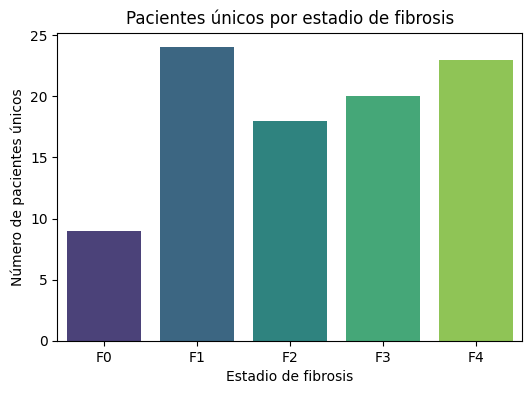

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contar pacientes únicos por estadio de fibrosis
pacientes_por_fibrosis = df_dx.groupby("FIBROSIS")["NUMPACIENTE"].nunique().reindex(["F0","F1","F2","F3","F4"])

plt.figure(figsize=(6,4))
sns.barplot(x=pacientes_por_fibrosis.index, y=pacientes_por_fibrosis.values, palette="viridis")
plt.title("Pacientes únicos por estadio de fibrosis")
plt.xlabel("Estadio de fibrosis")
plt.ylabel("Número de pacientes únicos")
plt.show()


### 5. Hoja: personales

In [ ]:
# Cargar hoja 'personales'
df_personales = pd.read_csv(f"{csv_folder}/personales.csv")
print(f"Dimensiones: {df_personales.shape}")
print(f"Columnas: {list(df_personales.columns)}")
df_personales.head()

Dimensiones: (120, 6)
Columnas: ['Codigo', 'FIBROSIS', 'NUMPACIENTE', 'FECHA_NACIMIENTO', 'EDAD_ACTUAL', 'SEXO_PAC']


,Codigo,FIBROSIS,NUMPACIENTE,FECHA_NACIMIENTO,EDAD_ACTUAL,SEXO_PAC
0,0-6,F0,6,1965-08-21,60,M
1,1-19,F1,29,1956-01-16,69,M
2,2-20,F2,68,1973-03-05,52,M
3,2-1,F2,49,1984-01-09,41,M
4,1-22,F1,32,1970-03-08,55,F


### **Analisis Grafico**

C:\Users\wired\AppData\Local\Temp\ipykernel_20744\3310464267.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="SEXO_PAC", data=df_personales, palette="pastel")


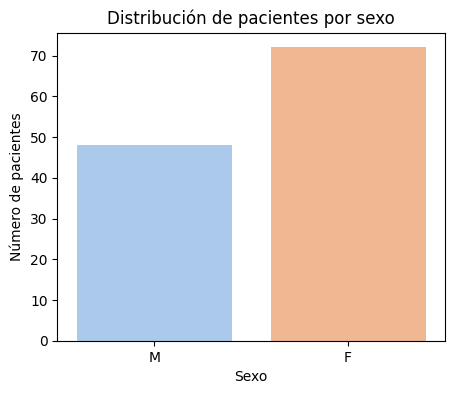

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.countplot(x="SEXO_PAC", data=df_personales, palette="pastel")
plt.title("Distribución de pacientes por sexo")
plt.xlabel("Sexo")
plt.ylabel("Número de pacientes")
plt.show()


C:\Users\wired\AppData\Local\Temp\ipykernel_20744\348017114.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="FIBROSIS", y="EDAD_ACTUAL", data=df_personales, order=["F0","F1","F2","F3","F4"], palette="mako")


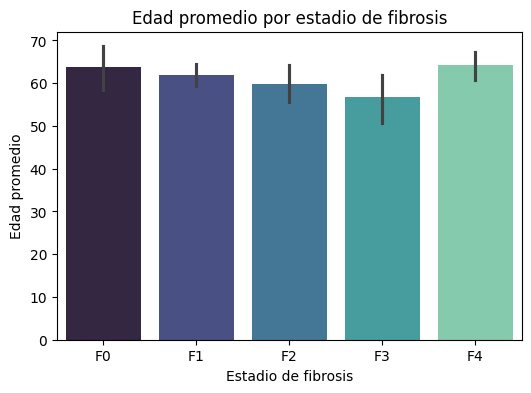

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x="FIBROSIS", y="EDAD_ACTUAL", data=df_personales, order=["F0","F1","F2","F3","F4"], palette="mako")
plt.title("Edad promedio por estadio de fibrosis")
plt.xlabel("Estadio de fibrosis")
plt.ylabel("Edad promedio")
plt.show()


La gráfica muestra que la edad promedio de los pacientes con fibrosis hepática se concentra alrededor de los 60 años en todos los estadios, con ligeras variaciones. Aunque no se observa una relación lineal clara entre edad y severidad, los estadios más avanzados (F3 y F4) también se presentan principalmente en adultos mayores, lo que es coherente con la progresión crónica de la enfermedad hepática a lo largo del tiempo.

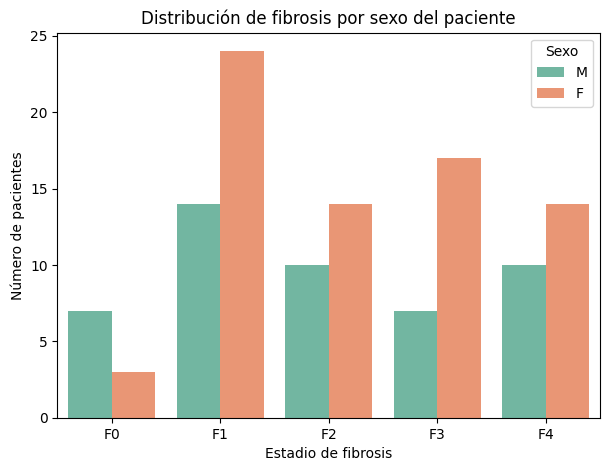

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(x="FIBROSIS", hue="SEXO_PAC", data=df_personales, order=["F0","F1","F2","F3","F4"], palette="Set2")
plt.title("Distribución de fibrosis por sexo del paciente")
plt.xlabel("Estadio de fibrosis")
plt.ylabel("Número de pacientes")
plt.legend(title="Sexo")
plt.show()


La gráfica muestra la distribución del estadio de fibrosis según el sexo de los pacientes. Se observa que las mujeres presentan una mayor frecuencia en casi todos los estadios, especialmente en F1 y F3, mientras que los hombres son menos numerosos en cada categoría. Esto podría indicar una mayor detección o seguimiento en mujeres, o bien reflejar diferencias en la exposición a factores de riesgo o en la búsqueda de atención médica entre ambos sexos.


### **Analisis Conjunto de las hojas**

In [ ]:
# Unir df_personales y df_dx por la columna NUMPACIENTE
df_merged = pd.merge(df_dx, df_personales, on=["NUMPACIENTE", "FIBROSIS"], how="inner")


print(f"Dimensiones: {df_merged.shape}")
print(f"Columnas: {df_merged.columns.tolist()}")
print(f"Registros únicos de pacientes: {df_merged['NUMPACIENTE'].nunique()}")
print(f"Estadios de fibrosis presentes: {df_merged['FIBROSIS'].unique()}")


# Vista previa
df_merged.head()


Dimensiones: (900, 12)
Columnas: ['EVENTO', 'Codigo_x', 'FIBROSIS', 'NUMPACIENTE', 'DIAGNOSTICO', 'NOMBRE_DIAGNOSTICO', 'PRINCIPAL', 'FECHA_DIAGNOSTICO', 'Codigo_y', 'FECHA_NACIMIENTO', 'EDAD_ACTUAL', 'SEXO_PAC']
Registros únicos de pacientes: 94
Estadios de fibrosis presentes: ['F2' 'F3' 'F4' 'F1' 'F0']


,EVENTO,Codigo_x,FIBROSIS,NUMPACIENTE,DIAGNOSTICO,NOMBRE_DIAGNOSTICO,PRINCIPAL,FECHA_DIAGNOSTICO,Codigo_y,FECHA_NACIMIENTO,EDAD_ACTUAL,SEXO_PAC
0,31,2-10,F2,58,E660,OBESIDAD DEBIDA A EXCESO DE CALORIAS,N,2023-05-23 08:42:52,2-10,1951-08-02,74,F
1,32,2-10,F2,58,K760,"DEGENERACION GRASA DEL HIGADO, NO CLASIFICADAS...",N,2023-05-23 09:42:43,2-10,1951-08-02,74,F
2,46,2-10,F2,58,K740,FIBROSIS HEPATICA,N,2024-05-24 15:44:58,2-10,1951-08-02,74,F
3,41,2-10,F2,58,R945,RESULTADOS ANORMALES EN ESTUDIOS FUNCIONALES D...,N,2024-02-14 16:02:28,2-10,1951-08-02,74,F
4,38,2-10,F2,58,K760,"DEGENERACION GRASA DEL HIGADO, NO CLASIFICADAS...",N,2023-12-21 14:51:22,2-10,1951-08-02,74,F


In [ ]:
print(f"Total de registros combinados: {len(df_merged)}")
print(f"Pacientes únicos: {df_merged['NUMPACIENTE'].nunique()}")
print(f"Estadios de fibrosis: {df_merged['FIBROSIS'].unique().tolist()}\n")

Total de registros combinados: 900
Pacientes únicos: 94
Estadios de fibrosis: ['F2', 'F3', 'F4', 'F1', 'F0']



In [ ]:
edad_fibrosis_sexo = df_merged.groupby(["FIBROSIS", "SEXO_PAC"])["EDAD_ACTUAL"].mean().round(1)
print("Edad promedio por estadio y sexo:")
print(edad_fibrosis_sexo)

Edad promedio por estadio y sexo:
FIBROSIS  SEXO_PAC
F0        F           60.4
          M           67.9
F1        F           60.0
          M           64.0
F2        F           68.7
          M           59.5
F3        F           60.2
          M           62.8
F4        F           64.4
          M           64.1
Name: EDAD_ACTUAL, dtype: float64


C:\Users\wired\AppData\Local\Temp\ipykernel_20744\2190075703.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_merged, x="FIBROSIS", y="EDAD_ACTUAL", hue="SEXO_PAC", ci=None)


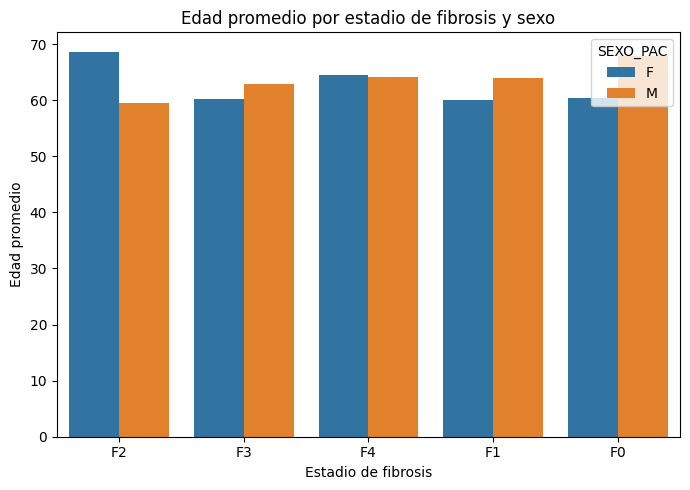

In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(data=df_merged, x="FIBROSIS", y="EDAD_ACTUAL", hue="SEXO_PAC", ci=None)
plt.title("Edad promedio por estadio de fibrosis y sexo")
plt.xlabel("Estadio de fibrosis")
plt.ylabel("Edad promedio")
plt.tight_layout()
plt.show()


In [ ]:
# Edad promedio por diagnóstico (Top 10 más frecuentes)
edad_diagnostico = (
    df_merged.groupby("NOMBRE_DIAGNOSTICO")["EDAD_ACTUAL"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

print("Edad promedio por diagnóstico (Top 10 más frecuentes):\n")
print(edad_diagnostico.to_string(index=False))


Edad promedio por diagnóstico (Top 10 más frecuentes):

                                                                                                                                                      NOMBRE_DIAGNOSTICO  EDAD_ACTUAL
DIABETES MELLITUS  NO INSULINODEPENDIENTE, (SIN OBESIDAD),(CON OBESIDAD): DE COMIENZO EN EL ADULTO, DE COMIENZO EN LA MADUREZ DEL ADULTO, ESTABLE, NO CETÓSICA, TIPO II.    69.000000
                                                                                                                                                       FIBROSIS HEPATICA    68.931034
                                                                                                                 RESULTADOS ANORMALES EN ESTUDIOS FUNCIONALES DEL HIGADO    68.500000
                                                                                                                                                     OTRA HIPERLIPIDEMIA    68.000000
                                  

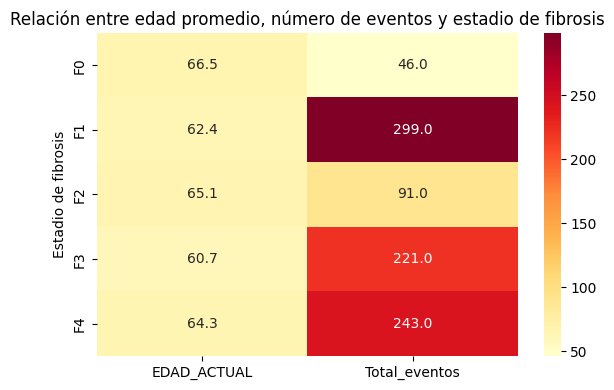

In [ ]:
edad_eventos = (
    df_merged.groupby("FIBROSIS")[["EDAD_ACTUAL", "EVENTO"]]
    .agg({"EDAD_ACTUAL": "mean", "EVENTO": "count"})
    .rename(columns={"EVENTO": "Total_eventos"})
)

plt.figure(figsize=(6,4))
sns.heatmap(edad_eventos, annot=True, cmap="YlOrRd", fmt=".1f")
plt.title("Relación entre edad promedio, número de eventos y estadio de fibrosis")
plt.ylabel("Estadio de fibrosis")
plt.tight_layout()
plt.show()


La gráfica muestra que la edad promedio de los pacientes se mantiene estable entre los distintos estadios de fibrosis (entre 60 y 66 años), por lo que la edad no parece ser un factor diferenciador claro. Sin embargo, los estadios F1, F3 y F4 concentran un mayor número de eventos clínicos, lo que sugiere que los pacientes con fibrosis leve o avanzada requieren más seguimiento o presentan una mayor actividad médica, mientras que los casos sin fibrosis (F0) muestran menos registros.